# Exploring Boston Airbnb Data

## 1. Overview of the Data

In [1]:
# Import packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import calendar as cal

import geopy

import folium
from folium.plugins import MarkerCluster

In [2]:
# Import the data
calendar = pd.read_csv('./data/calendar.csv')
listings = pd.read_csv('./data/listings.csv')

### a. Calendar data

In [3]:
# Check the shape and components of the calendar data
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In [4]:
calendar.head(2)

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN


In [5]:
calendar.tail(2)

,listing_id,date,available,price
1308888,14504422,2016-09-07,f,NaN
1308889,14504422,2016-09-06,f,NaN


In [6]:
calendar[calendar['available'] == 't'].head(2)

,listing_id,date,available,price
365,3075044,2017-08-22,t,$65.00
366,3075044,2017-08-21,t,$65.00


In [7]:
# Check if there's any missing values
def columns_with_null(df):
    '''
    Function to find columns with missing values
    
    Args:
        df: a Dataframe
        
    Returns:
        Dataframe: a dataframe with column names, number of missing values, and percentage of missing values
    '''
    
    cols = df.columns[df.isnull().sum() > 0]
    df_null = pd.DataFrame(df[cols].isnull().sum().sort_values(), columns=['# of Nulls'])
    df_null['Null %'] = df[cols].isnull().mean().sort_values()
    return df_null

columns_with_null(calendar)

,# of Nulls,Null %
price,665853,0.508716


In [8]:
# Check if there's any wrong entry such that the price isn't null when the list is not available and vice versa
print(calendar[calendar['available'] == 'f']['price'].isnull().mean() == 1)
print(sum(calendar[calendar['available'] == 't']['price'].isnull()) == 0)

True
True


The data in calendar.csv includes theinformation about the avalability and price of the listings of Airbnb in Boston area for one year, from 2016-09-06 to 2017-09-05. Each enry includes the listing id, the date, and the availability of the listing property with the corresponding price at that date. <br/>
No missing value is found in the data except that about half of the entries have null values for the price, since the price information is unknown if the property is unavailable at that date.<br/>
Further information such as which time during the year are these properties most popular and which properties are most popular can be extracted later. Also, the format of the price and data columns need to be transformed. 

### b. Listings data

In [9]:
# Check the shape and components of the listings data
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [10]:
pd.set_option('display.max_columns', 100)
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United Sta

In [11]:
# Check the numeric columns
listings_num = listings.select_dtypes(include=['float64', 'int64'])
print('In total %d columns with numeric values.' % len(listings_num.columns))
listings_num.columns

In total 33 columns with numeric values.


Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'guests_included', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'jurisdiction_names',
       'calculated_host_listings_count', 'reviews_per_month'],
      dtype='object')

In [12]:
# Check if each entry for a unique id
listings.shape[0] == len(listings['id'].unique())

True

In [13]:
# Check if there's any missing values
columns_with_null(listings)

,# of Nulls,Null %
city,2,0.000558
property_type,3,0.000837
beds,9,0.002510
bedrooms,10,0.002789
host_location,11,0.003068
market,14,0.003905
bathrooms,14,0.003905
zipcode,38,0.010600
summary,143,0.039888
host_neighbourhood,339,0.094561


The data in listings.csv includes a lot of information about listings and each entry represents the information about a unique entry. There are in total 95 columns and 33 of these are numeric columns.<br/>
Quite a few columns in the dataset have missing values. For columns of jurisdiction_names, license, neighbourhood_group_cleansed, and has_availability with 100% missing values, we can simply drop these columns, for other columns, further engineering is required.<br/>
Questions like in which area the prices of propties are higher and how the average ratings is related to other factors such as price and zipcode can be explored. In addition, the predictive model for price can be constructed based on the dataset.

## 2. Analysis of the Data

Before constructing a predictive model for Airbnb price in Bostan, we could further dig into the data and find the answers to some of the questions of interests like raised above.

### a. How the overall trend changes with time
In this section, we will explore how the average price of listed properties and the total number of available listed properties changes by month.

In [14]:
# Transform the format of date
calendar_cleaned = calendar.copy()
calendar_cleaned['date'] = pd.to_datetime(calendar_cleaned['date'], format='%Y-%m-%d')

def price_reformat(df, col):
    '''
    Function to re-format the price into a float, i.e. $1,305.00 (str) -> 1305.00 (float)
    
    Args:
        df: a Dataframe
        col: string, the name of the column to transform
        
    Returns:
        Dataframe: the datafram with the selected column re-formatted
    '''
    
    df[col] = df[col].str.replace('$', '').str.replace(',', '').astype(float)
    return df

calendar_cleaned = price_reformat(calendar_cleaned, 'price')

calendar_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1308890 non-null  int64         
 1   date        1308890 non-null  datetime64[ns]
 2   available   1308890 non-null  object        
 3   price       643037 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 39.9+ MB


We are interested in overall trend that how popular and price of the properties change with time. Fistyly, we have to group the data by time (here we choose to fistly group by month). 

In [15]:
# Create the column for month
calendar_cleaned['month'] = calendar_cleaned['date'].apply(lambda x: x.month)

In [16]:
# Group by month and calculate the corresponding availability and average price
calendar_avail = calendar_cleaned[calendar_cleaned['available'] == 't']
avail_by_month = calendar_avail.groupby('month')['available'].count().reset_index(name='counts').sort_values(by='month')
avail_by_month['month'] = avail_by_month['month'].apply(lambda x: cal.month_abbr[x])
price_by_month = calendar_avail.groupby('month')['price'].mean().reset_index(name='avg price').sort_values(by='month')
price_by_month['month'] = price_by_month['month'].apply(lambda x: cal.month_abbr[x])

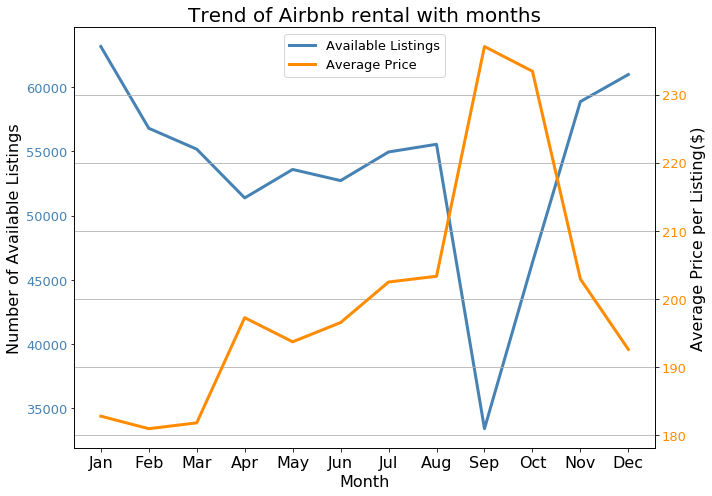

In [17]:
# Visualize the trend
fig, ax1 = plt.subplots(figsize=(10, 7))
# fig.suptitle('Trend of Airbnb rental with months', fontsize = 20)

ax1.set_xlabel('Month', fontsize = 16)
ax1.set_ylabel('Number of Available Listings', fontsize = 16)
l1 = ax1.plot(avail_by_month['month'], avail_by_month['counts'], color = 'steelblue', lw = 3, label = 'Available Listings')
ax1.set_title('Trend of Airbnb rental with months', fontsize = 20)
ax1.tick_params(axis='y', labelcolor='steelblue', labelsize = 13)
ax1.tick_params(axis='x', labelsize = 16)

ax2 = ax1.twinx()

ax2.set_ylabel('Average Price per Listing($)', fontsize = 16)
l2 = ax2.plot(price_by_month['month'], price_by_month['avg price'], color = 'darkorange', lw = 3, label = 'Average Price')
ax2.tick_params(axis='y', labelcolor='darkorange', labelsize = 13)

ls = l1+l2
labs = [l.get_label() for l in ls]
ax1.legend(ls, labs, loc = 'upper center', fontsize = 13)

plt.grid(True)
plt.tight_layout()
plt.savefig('./figs/time_trend.png', dpi = 300, bbox_inches='tight')
plt.show()

From the results shown above, we can see that, the overall trend of total number of available lists is approximately the opposite to that of the average price with months, which makes sense.<br/>
The most busy seasons for visiting Boston are September and October, in which the averange price is also the highest among the whole year. On the other hand, From November to Jan, there tends to be more available propties, while the the number of available properties is relatively simialr for other months. The mean price of available properties are lowest from Dec to March.

### How the overall statistcs of properties changes with location (zip code)?
In this section, we will explore how the average price, avearge rating, popularity of rentals, and number of listed properties change with location, as visualized on the map.

In [18]:
# Convert price to float
listings_cleaned = listings.copy()
listings_cleaned = price_reformat(listings_cleaned, 'price')

In [19]:
# Check if there's any missing/wrong entries for the listed properties during the period of one year
cal_by_id = calendar_cleaned.groupby('listing_id')['available'].count().reset_index(name='total')
cal_by_id['total'].value_counts()

365    3584
730       1
Name: total, dtype: int64

We can see that it seems that all entries for one property are duplicated, but this is going to be fine when we calculate the percentage of availability due the periode of one year, so we will keep this.

In [20]:
cal_avail_by_id = calendar_avail.groupby('listing_id')['available'].count().reset_index(name='avail')
cal_by_id = cal_by_id.merge(cal_avail_by_id, how='left', on='listing_id')

# Fill the null values with 0 since null here means no availability throughout the year
cal_by_id['avail'].fillna(value=0, inplace=True)

# Compute the availability rate
cal_by_id['non_avail_rate'] = cal_by_id['avail'] / cal_by_id['total']

In [21]:
# Rename the columns and drop unnecessary columns
cal_by_id.rename(columns={'listing_id':'id'}, inplace=True)
cal_by_id.drop(['total', 'avail'], axis=1, inplace=True)

In [22]:
# Add the column of the percentage of non-availability for each id
listings_cleaned = listings_cleaned.merge(cal_by_id, how='left', on='id')

After adding in the data  we needed for anlysis from the calendar dataset, we have to filter the useful features for further predictive model. Firtsly, we choose to remove those columns with more than 30% missing values like weekly_price, monthly_price, square_feet, jurisdiction_names, license ,neighbourhood_group_cleansed, and so on, since none of these seems helpful for predicting prices.<br/>
Then, at this time, we only want to focus on numerical predictors and those features that can be transformed into one-hot variables.<br.>
Also, we don't want to include those features with little variance like market, smart_location, and host_has_profile_pic, we choose to keep selected features as shown below.

In [23]:
# Select the columns we care about in this section asl well as for predicting price and check the missing values
listings_prd = listings_cleaned.loc[:, ['price', 'review_scores_rating', 'number_of_reviews', 'non_avail_rate', 'zipcode',
                                        'latitude', 'longitude', 'host_is_superhost', 'property_type', 'room_type',
                                        'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'guests_included',
                                        'extra_people', 'availability_30', 'availability_60', 'availability_90',
                                        'availability_365', 'is_location_exact', 'host_listings_count', 'instant_bookable',
                                        'cancellation_policy', 'require_guest_profile_picture', 'host_identity_verified',
                                        'require_guest_phone_verification', 'amenities']]
columns_with_null(listings_prd)

,# of Nulls,Null %
property_type,3,0.000837
beds,9,0.002510
bedrooms,10,0.002789
bathrooms,14,0.003905
zipcode,38,0.010600
review_scores_rating,813,0.226778


Since we care about the ratings received for the listed properties and it's hard to impute the missing values for these rows, we'll remove these rows with missing ratings.

In [24]:
listings_prd.head()

,price,review_scores_rating,number_of_reviews,non_avail_rate,zipcode,latitude,longitude,host_is_superhost,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,extra_people,availability_30,availability_60,availability_90,availability_365,is_location_exact,host_listings_count,instant_bookable,cancellation_policy,require_guest_profile_picture,host_identity_verified,require_guest_phone_verification,amenities
0,250.0,NaN,0,0.000000,02131,42.282619,-71.133068,f,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,1,$0.00,0,0,0,0,t,1,f,moderate,f,f,f,"{TV,""Wireless Internet"",Kitchen,""Free Parking ..."
1,65.0,94.0,36,0.983562,02131,42.286241,-71.134374,f,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,0,$0.00,26,54,84,359,t,1,t,moderate,f,t,f,"{TV,Internet,""Wireless Internet"",""Air Conditio..."
2,65.0,98.0,41,0.873973,02131,42.292438,-71.135765,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,1,$20.00,19,46,61,319,t,1,f,moderate,t,t,f,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit..."
3,75.0,100.0,1,0.268493,NaN,42.281106,-71.121021,f,House,Private room,4,1.0,1.0,2.0,Real Bed,2,$25.00,6,16,26,98,f,1,f,moderate,f,f,f,"{TV,Internet,""Wireless Internet"",""Air Conditio..."
4,79.0,99.0,29,0.915068,02131,42.284512,-71.136258,t,House,Private room,2,1.5,1.0,2.0,Real Bed,1,$0.00,13,34,59,334,t,1,f,flexible,f,t,f,"{Internet,""Wireless Internet"",""Air Conditionin..."


In [25]:
listings_prd.dropna(axis=0, subset=['review_scores_rating'], inplace=True)
listings_prd.reset_index(drop=True, inplace=True)
listings_prd['review_scores_rating'].describe()

count    2772.000000
mean       91.916667
std         9.531686
min        20.000000
25%        89.000000
50%        94.000000
75%        98.250000
max       100.000000
Name: review_scores_rating, dtype: float64

In [26]:
# Use the latitude and longitude to find it
def coordinate_to_zipcode(df, lat=None, lon=None, zipcode=None, is_coordinate=True):
    '''
    Function to apply on a Dataframe to convert latitude and longitude to corresponding zipcode
    
    Args:
        df: a Datafram
        lat/lon/zipcode: string, the column name for the latitude/longitude/code
        is_coordinate: boolean, convert from coordinate to zipcode or vice versa
        
    Returns:
        Series: a series with the converted zipcode/(latitude and longitude)
    '''
    
    geolocator = geopy.Nominatim(user_agent='czh')
    
    if is_coordinate:
        loc = geolocator.reverse((df[lat], df[lon]))
        return loc.raw['address']['postcode']
    else:
        # Specify the country for querying
        loc = geolocator.geocode(df[zipcode], country_codes ='US')
        return (loc.latitude, loc.longitude)

In [27]:
listings_prd.head()

,price,review_scores_rating,number_of_reviews,non_avail_rate,zipcode,latitude,longitude,host_is_superhost,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,extra_people,availability_30,availability_60,availability_90,availability_365,is_location_exact,host_listings_count,instant_bookable,cancellation_policy,require_guest_profile_picture,host_identity_verified,require_guest_phone_verification,amenities
0,65.0,94.0,36,0.983562,02131,42.286241,-71.134374,f,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,0,$0.00,26,54,84,359,t,1,t,moderate,f,t,f,"{TV,Internet,""Wireless Internet"",""Air Conditio..."
1,65.0,98.0,41,0.873973,02131,42.292438,-71.135765,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,1,$20.00,19,46,61,319,t,1,f,moderate,t,t,f,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit..."
2,75.0,100.0,1,0.268493,NaN,42.281106,-71.121021,f,House,Private room,4,1.0,1.0,2.0,Real Bed,2,$25.00,6,16,26,98,f,1,f,moderate,f,f,f,"{TV,Internet,""Wireless Internet"",""Air Conditio..."
3,79.0,99.0,29,0.915068,02131,42.284512,-71.136258,t,House,Private room,2,1.5,1.0,2.0,Real Bed,1,$0.00,13,34,59,334,t,1,f,flexible,f,t,f,"{Internet,""Wireless Internet"",""Air Conditionin..."
4,75.0,100.0,8,0.158904,02131,42.291690,-71.131893,t,Condominium,Private room,2,1.0,1.0,1.0,Real Bed,1,$0.00,5,28,58,58,t,2,f,flexible,f,t,f,"{""Cable TV"",""Wireless Internet"",""Air Condition..."


In [28]:
# Get the corresponding value based on the coordinates for the rows with missing zipcode
zipcode_sub = listings_prd[listings_prd['zipcode'].isnull()].apply(coordinate_to_zipcode, 
                                                                   lat='latitude', lon='longitude', axis=1)
# Fill in the missing values
listings_prd['zipcode'].fillna(zipcode_sub, inplace=True)

In [29]:
listings_prd['zipcode'].value_counts()

02116          289
02130          283
02118          214
02114          176
02134          172
02127          160
02215          146
02128          137
02135          127
02115          124
02125          111
02119           88
02113           83
02120           78
02124           68
02129           67
02108           67
02111           65
02131           59
02210           52
02122           37
02109           36
02132           27
02136           23
02121           22
02126           18
02110           11
02145            5
02143            3
02467            3
02163            3
02138            2
02141            2
02130-0947       2
02446            2
02445            2
02139            1
02186            1
02134-1704       1
02199            1
02142            1
02134-1433       1
02108 02111      1
02131-3025       1
Name: zipcode, dtype: int64

In [30]:
# Remove the part after '-' in zipcode 
listings_prd.replace({'02130-0947':'02130',
                      '02131-3025':'02131',
                      '02134-1704':'02134',
                      '02134-1433':'02134'}, inplace=True)

listings_prd.drop(listings_prd[listings_prd['zipcode'] == '02108 02111'].index, inplace=True)

# Keep the rows with the zipcode of at least 20 appearances for further analysis using average statistics
zipcode_keep = list(listings_prd['zipcode'].value_counts()[listings_prd['zipcode'].value_counts() > 20].index)
listings_loc = listings_prd[listings_prd['zipcode'].isin(zipcode_keep)][['price', 'review_scores_rating', 'number_of_reviews', 
                                                                         'non_avail_rate', 'zipcode', 'latitude', 'longitude']]

In [31]:
listings_loc.head()

,price,review_scores_rating,number_of_reviews,non_avail_rate,zipcode,latitude,longitude
0,65.0,94.0,36,0.983562,02131,42.286241,-71.134374
1,65.0,98.0,41,0.873973,02131,42.292438,-71.135765
2,75.0,100.0,1,0.268493,02131,42.281106,-71.121021
3,79.0,99.0,29,0.915068,02131,42.284512,-71.136258
4,75.0,100.0,8,0.158904,02131,42.291690,-71.131893


In [32]:
# Visualize the distribution of price, review_scores_rating, and non_avail_rate
sns.set(color_codes=True)
def vis_dist_hist(df, col_x, x_label=None, bins = 20, set_title=True):
    '''
    Function to visualize the histgram of one numeric feature in the dataset 
    
    Args:
        df: a Dataframe
        col_x: a string, the name of the column to visualize
        x_label: a string, name to show on the x-axis, if None, use col_x
        bins: an int, specify the number of bins used
        set_title: a boolean, if include the title
        
    Returns:
        None
    '''
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax = sns.distplot(listings_prd[col_x], bins=bins, kde=False)
    
    if x_label is None:
        x_label = col_x
    ax.set_xlabel(x_label, fontsize = 13)
    ax.set_ylabel('Counts', fontsize = 13)
    ax.set_title('Distribution of properties based on %s' % x_label , fontsize = 16)
    ax1.tick_params(axis='y', labelsize = 11)
    ax1.tick_params(axis='x', labelsize = 11)

    plt.tight_layout()
    plt.savefig('./figs/%s_dist.png' % x_label, dpi = 300, bbox_inches='tight')
    plt.show()

# Visualize the distribution of price, review_scores_rating, and non_avail_rate based on zipcode
def vis_dist_box(df, col_x, col_y, x_label=None, y_label=None, set_title=True):
    '''
    Function to visualize the distribution of one numeric feature based on another categorical feature in the dataset 
    
    Args:
        df: a Dataframe
        col_x: a string, the name of the column to categorize
        col_y: a string, the name of the column to visualize the distribution
        x_label: a string, name to show on the x-axis, if None, use col_x
        y_label: a string, name to show on the y-axis, if None, use col_y
        set_title: a boolean, if include the title
        
    Returns:
        None
    '''
    
    fig, ax = plt.subplots(figsize=(15, 5))
    ax = sns.boxplot(x=col_x, y=col_y, data=df)
    ax = sns.pointplot(x=col_x, y=col_y, data=df.groupby(col_x).median().reset_index())
    if x_label is None:
        x_label = col_x
    if y_label is None:
        y_label = col_y
    if set_title is True:
        ax.set_title('%s distribution on %s' % (y_label, x_label), fontsize = 20)
    ax.set_xlabel(x_label, fontsize = 16)
    ax.set_ylabel(y_label, fontsize = 16)
    ax.tick_params(axis='x', labelsize = 13, labelrotation = 30)
    ax.tick_params(axis='y', labelsize = 16)
    
    plt.grid(True, axis='y')
    plt.savefig('./figs/%s_vs_%s.png' % (y_label, x_label), dpi = 300, bbox_inches='tight')
    plt.show()

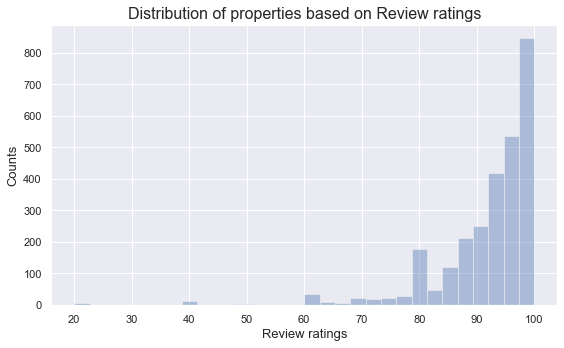

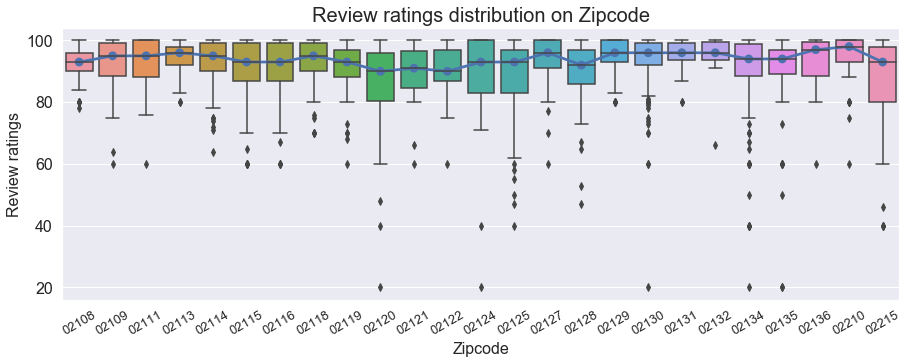

In [33]:
vis_dist_hist(listings_loc, 'review_scores_rating', 'Review ratings', bins=30)
vis_dist_box(listings_loc, 'zipcode', 'review_scores_rating', 'Zipcode', 'Review ratings')

In [34]:
listings_loc[listings_loc['review_scores_rating'] >= 90].shape[0] / listings_loc.shape[0]

0.7411634756995582

As calculated, approximatey 75% of the review ratings are in the range from 90 to 100, which are relatively high ratings. Meanwhile, only about 6% of the ratings are lower than 80.
As a result, we can see that zipcode (location) does not have a significant effect on the overall rating, although slight difference can be observed and the zipcode 02120 and 02215 tend to have lower ratings.

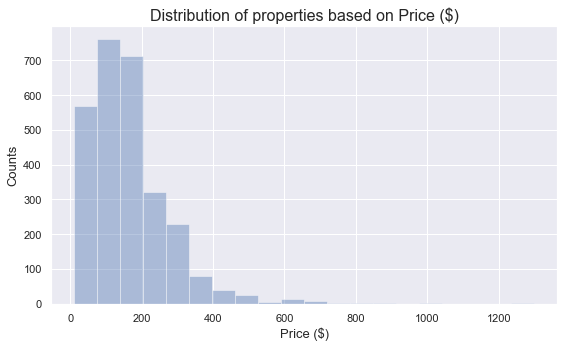

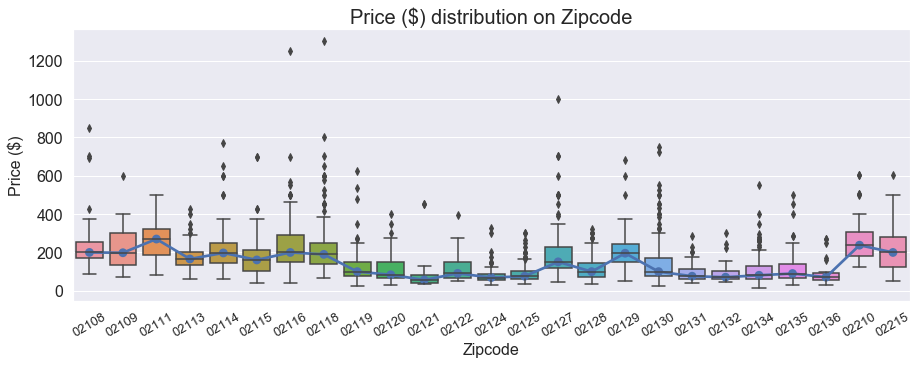

In [35]:
vis_dist_hist(listings_loc, 'price', 'Price ($)')
vis_dist_box(listings_loc, 'zipcode', 'price', 'Zipcode', 'Price ($)')

In [36]:
listings_loc[listings_loc['price'] <= 200].shape[0] / listings_loc.shape[0]

0.7352724594992637

One thing interesting about the price distribution is that, although the overall rating for zipcode 02215 is among the lowest of all locations, the price in this area isn't low.
Similarly, about 75% of the properties have the price lower than 200, more than 95% have the price lower than 400. We'll check back later about the patterns for other features based on the price.

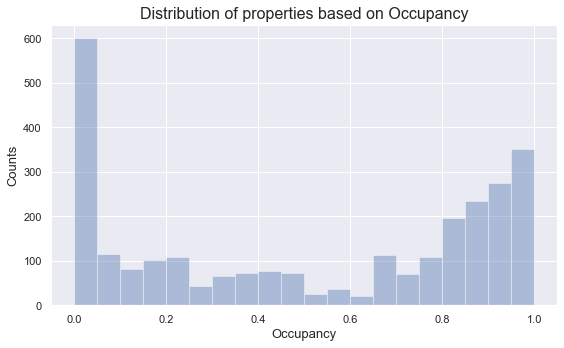

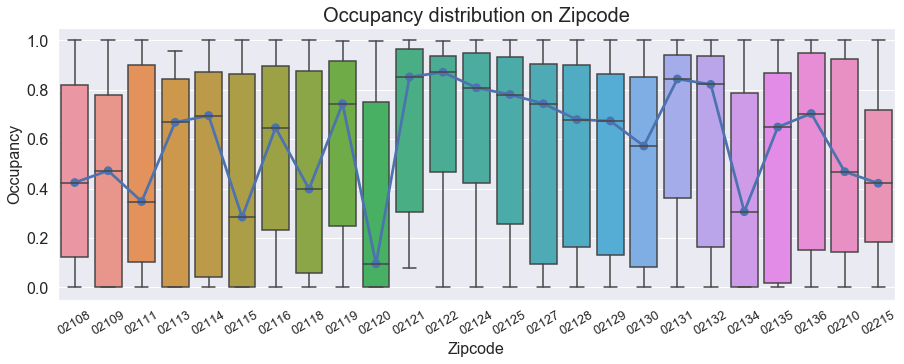

In [37]:
vis_dist_hist(listings_loc, 'non_avail_rate', 'Occupancy')
vis_dist_box(listings_loc, 'zipcode', 'non_avail_rate', 'Zipcode', 'Occupancy')

In [38]:
listings_loc[(listings_loc['non_avail_rate'] > 0.2) & (listings_loc['non_avail_rate'] < 0.7)].shape[0] / listings_loc.shape[0]

0.22864506627393225

The distribution of occupancy shows a interesting patter which are different from those the price and occupancy, the rented ratio is either relatively high or extremly low, which is also reflected in the boxplot based on zipcode that few medians is close to 0.5.<br/>
In addition, the freqency for occupancy between 0.2 and 0.7 is low, which is about 20%. We'll later check how other features are related to low/high occupancy after imputing all missing values.

In [39]:
# Compute the average price, avearge rating, popularity of rentals, and number of listed properties vs. zipcode
listings_loc['total__rating_scores'] = listings_loc['review_scores_rating'] * listings_loc['number_of_reviews']
listings_group_1 = listings_loc.groupby('zipcode')[['total__rating_scores', 'price', 'number_of_reviews']].sum().reset_index()

listings_group_2 = listings_loc.groupby('zipcode')['price'].count().reset_index(name='counts')

listings_group_3 = listings_loc.groupby('zipcode')['non_avail_rate'].mean().reset_index()

listings_group = listings_group_1.merge(listings_group_3, how='left', on='zipcode').merge(listings_group_2, how='left', on='zipcode')

listings_group['avg_price'] = listings_group['price'] / listings_group['counts']
listings_group['avg_rating'] = listings_group['total__rating_scores'] / listings_group['number_of_reviews']

listings_group.drop(['total__rating_scores', 'price', 'number_of_reviews'], axis=1, inplace=True)

In [40]:
# Add back in the coordinates for each zipcode
coords = listings_group.apply(coordinate_to_zipcode, zipcode='zipcode', is_coordinate=False, axis=1)

lat_list = []
lon_list = []
for idx, value in coords.items():
    lat, lon = value
    lat_list.append(lat)
    lon_list.append(lon)
    
listings_group['lat'] = lat_list
listings_group['lon'] = lon_list

listings_group.head(2)

,zipcode,non_avail_rate,counts,avg_price,avg_rating,lat,lon
0,02108,0.466367,67,230.716418,91.925965,42.357711,-71.063649
1,02109,0.445205,36,224.472222,92.212121,42.360073,-71.054879


In [41]:
# Visualize based on zipcode on map
map_Boston = folium.Map(location=[42.321806, -71.089982], tiles='Stamen Terrain', zoom_start=12, prefer_canvas=True)

In [42]:
# Visualize each list
mc = MarkerCluster()

for row in listings_prd.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude, row.longitude],
                               popup='Price: ${0:.1f}\nRating: {1:.2f}\nAvailability:{2:.2f}%'.format(
                                   row.price, row.review_scores_rating, (1 - row.non_avail_rate) * 100)))
    
mc.add_to(map_Boston)

In [43]:
# Visualize the avaraged statistics
for row in listings_group.itertuples():
    folium.Circle(
        location=[row.lat, row.lon],
        radius=row.counts * 2,
        popup='Zipcode: {0}\n# of listings: {1}\nPrice: ${2:.1f}\nRating: {3:.2f}\nAvailability:{4:.2f}%'.format(
            row.zipcode, row.counts, row.avg_price, row.avg_rating, (1 - row.non_avail_rate) * 100),
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map_Boston)
    
map_Boston.save('./figs/Boston_map.html')

In [44]:
map_Boston

# 3. Modeling the Price

## a. Data cleaning 

In [45]:
# Drop unnecessary columns including latitude and longitude
listings_prd.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [46]:
# Check the missing values in the dataset
columns_with_null(listings_prd)

,# of Nulls,Null %
property_type,2,0.000722
beds,6,0.002165
bedrooms,7,0.002526
bathrooms,12,0.004331


In [47]:
# Start with the bathrooms with the most missing values
listings_prd[listings_prd['bathrooms'].isnull()]

,price,review_scores_rating,number_of_reviews,non_avail_rate,zipcode,host_is_superhost,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,extra_people,availability_30,availability_60,availability_90,availability_365,is_location_exact,host_listings_count,instant_bookable,cancellation_policy,require_guest_profile_picture,host_identity_verified,require_guest_phone_verification,amenities
87,85.0,94.0,17,0.989041,02130,f,House,Private room,2,NaN,1.0,1.0,Real Bed,1,$0.00,26,56,86,361,t,1,f,moderate,f,t,f,"{Internet,""Wireless Internet"",""Air Conditionin..."
596,99.0,91.0,73,0.821918,02108,f,Apartment,Entire home/apt,2,NaN,1.0,NaN,Real Bed,1,$0.00,0,20,46,300,t,11,t,strict,f,f,f,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
636,167.0,82.0,54,0.898630,02118,f,Apartment,Entire home/apt,4,NaN,1.0,1.0,Real Bed,1,$0.00,17,33,53,328,t,24,f,strict,f,t,f,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
653,60.0,58.0,10,0.997260,02125,f,Bed & Breakfast,Private room,2,NaN,1.0,NaN,Real Bed,1,$20.00,29,59,89,364,f,3,t,strict,f,f,f,"{""Air Conditioning"",""Free Parking on Premises""..."
658,60.0,62.0,14,0.991781,02125,f,House,Private room,2,NaN,1.0,NaN,Real Bed,1,$20.00,27,57,87,362,f,3,t,flexible,f,f,f,"{TV,""Air Conditioning"",""Free Parking on Premis..."
708,163.0,86.0,65,0.778082,02118,f,Apartment,Entire home/apt,4,NaN,1.0,1.0,Real Bed,1,$0.00,4,16,39,284,t,24,f,strict,f,t,f,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
792,98.0,91.0,184,0.901370,02116,f,House,Private room,1,NaN,1.0,1.0,Real Bed,1,$0.00,11,28,54,329,t,5,f,moderate,f,t,f,"{""Cable TV"",Internet,""Wireless Internet"",""Air ..."
897,135.0,88.0,215,0.920548,02116,f,Bed & Breakfast,Private room,1,NaN,1.0,1.0,Real Bed,1,$12.00,6,34,61,336,t,5,f,moderate,f,t,f,"{Internet,""Wireless Internet"",""Air Conditionin..."
1747,249.0,100.0,1,0.997260,02115,f,Apartment,Private room,3,NaN,1.0,1.0,Real Bed,1,$0.00,29,59,89,364,t,558,f,super_strict_30,f,t,t,"{TV,""Cable TV"",Internet,""Air Conditioning"",""Wh..."
1751,349.0,88.0,9,0.997260,02215,f,Apartment,Entire home/apt,4,NaN,2.0,2.0,Real Bed,1,$0.00,29,59,89,364,t,558,f,super_strict_30,f,t,t,"{TV,""Cable TV"",Internet,""Air Conditioning"",""Wh..."


In [48]:
listings_prd['bathrooms'].value_counts() / listings.shape[0]

1.0    0.598326
2.0    0.093445
1.5    0.047978
2.5    0.015621
3.0    0.004463
3.5    0.003347
0.0    0.002510
0.5    0.001395
6.0    0.001116
5.0    0.000558
4.0    0.000558
4.5    0.000279
Name: bathrooms, dtype: float64

In [49]:
listings_prd['bedrooms'].value_counts() / listings.shape[0]

1.0    0.514086
2.0    0.141980
0.0    0.065551
3.0    0.034868
4.0    0.011158
5.0    0.003347
Name: bedrooms, dtype: float64

We can see that more than half of the listed properties have one bathroon and the ratio of other numbers of bathrooms is all lower than 10%, so we choose to fill the missing values with the mode 1.

In [50]:
listings_prd['bathrooms'].fillna(1, inplace=True)

In [51]:
listings_prd[listings_prd['bedrooms'].isnull()]

,price,review_scores_rating,number_of_reviews,non_avail_rate,zipcode,host_is_superhost,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,extra_people,availability_30,availability_60,availability_90,availability_365,is_location_exact,host_listings_count,instant_bookable,cancellation_policy,require_guest_profile_picture,host_identity_verified,require_guest_phone_verification,amenities
730,229.0,89.0,9,0.991781,02118,f,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,1,$0.00,27,57,87,362,t,558,f,super_strict_30,f,t,t,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
894,269.0,91.0,1,0.978082,02118,f,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,1,$0.00,24,54,82,357,t,558,f,super_strict_30,f,t,t,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
908,225.0,90.0,4,0.978082,02118,f,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,2,$0.00,24,54,82,357,t,558,f,super_strict_30,f,t,t,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
1003,209.0,78.0,22,0.884932,02115,f,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,1,$0.00,10,29,48,323,t,558,f,super_strict_30,f,t,t,"{""Cable TV"",Internet,""Wireless Internet"",""Air ..."
1094,209.0,87.0,6,0.898630,02115,f,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,1,$0.00,11,31,53,328,t,558,f,super_strict_30,f,t,t,"{TV,""Cable TV"",Internet,""Air Conditioning"",Kit..."
1132,209.0,92.0,17,0.882192,02115,f,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,1,$0.00,8,28,47,322,t,558,f,super_strict_30,f,t,t,"{""Cable TV"",Internet,""Wireless Internet"",""Air ..."
1572,175.0,92.0,127,0.690411,02108,f,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,2,$0.00,2,8,8,252,t,6,t,strict,f,t,f,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."


In [52]:
listings_prd[listings_prd['beds'].isnull()]

,price,review_scores_rating,number_of_reviews,non_avail_rate,zipcode,host_is_superhost,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,extra_people,availability_30,availability_60,availability_90,availability_365,is_location_exact,host_listings_count,instant_bookable,cancellation_policy,require_guest_profile_picture,host_identity_verified,require_guest_phone_verification,amenities
405,99.0,100.0,1,0.063014,02120,f,Apartment,Private room,1,1.0,1.0,NaN,Real Bed,1,$50.00,0,0,23,23,f,1,f,moderate,f,t,f,"{""Wireless Internet"",""Air Conditioning"",Kitche..."
596,99.0,91.0,73,0.821918,02108,f,Apartment,Entire home/apt,2,1.0,1.0,NaN,Real Bed,1,$0.00,0,20,46,300,t,11,t,strict,f,f,f,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
653,60.0,58.0,10,0.997260,02125,f,Bed & Breakfast,Private room,2,1.0,1.0,NaN,Real Bed,1,$20.00,29,59,89,364,f,3,t,strict,f,f,f,"{""Air Conditioning"",""Free Parking on Premises""..."
658,60.0,62.0,14,0.991781,02125,f,House,Private room,2,1.0,1.0,NaN,Real Bed,1,$20.00,27,57,87,362,f,3,t,flexible,f,f,f,"{TV,""Air Conditioning"",""Free Parking on Premis..."
2180,57.0,87.0,12,0.964384,02124,f,House,Private room,2,1.0,1.0,NaN,Real Bed,1,$12.00,17,47,77,352,t,1,f,flexible,f,f,f,"{Internet,""Wireless Internet"",Kitchen,""Pets li..."
2219,60.0,93.0,3,0.980822,02125,f,House,Private room,2,1.0,1.0,NaN,Real Bed,1,$20.00,23,53,83,358,f,3,t,strict,f,f,f,"{Internet,""Air Conditioning"",Kitchen,""Free Par..."


In [53]:
listings_prd['beds'].value_counts() / listings.shape[0]

1.0     0.468340
2.0     0.198884
3.0     0.060251
4.0     0.025384
5.0     0.008926
6.0     0.003905
7.0     0.001953
8.0     0.001674
0.0     0.001116
9.0     0.000558
16.0    0.000279
Name: beds, dtype: float64

In [54]:
# Similarly, fill the missing values for bedrooms and beds using 1
listings_prd['bedrooms'].fillna(1, inplace=True)
listings_prd['beds'].fillna(1, inplace=True)

In [55]:
listings_prd[listings_prd['property_type'].isnull()]

,price,review_scores_rating,number_of_reviews,non_avail_rate,zipcode,host_is_superhost,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,extra_people,availability_30,availability_60,availability_90,availability_365,is_location_exact,host_listings_count,instant_bookable,cancellation_policy,require_guest_profile_picture,host_identity_verified,require_guest_phone_verification,amenities
1055,199.0,85.0,26,0.287671,02116,f,NaN,Entire home/apt,2,1.0,0.0,1.0,Real Bed,2,$10.00,16,32,59,105,t,363,t,strict,f,t,f,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
2650,115.0,60.0,2,0.117808,02134,f,NaN,Private room,1,1.0,1.0,1.0,Real Bed,1,$0.00,3,13,43,43,t,4,f,moderate,f,f,f,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."


In [56]:
listings_prd['property_type'].value_counts() / listings.shape[0]

Apartment          0.552022
House              0.133612
Condominium        0.049372
Townhouse          0.012831
Loft               0.008926
Bed & Breakfast    0.008368
Boat               0.003068
Other              0.002510
Dorm               0.000558
Villa              0.000558
Guesthouse         0.000279
Entire Floor       0.000279
Name: property_type, dtype: float64

The two rows with missing values in property_type have only either zero or one bedroom, and the Apartment accounts for more than 50% of the types, so we will fill the missing values for these two rows with Apartment.

In [57]:
listings_prd['property_type'].fillna('Apartment', inplace=True)

In [58]:
# Check the missing values
columns_with_null(listings_prd)

,# of Nulls,Null %


In [59]:
# Check the types of the columns
listings_prd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2771 entries, 0 to 2771
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   price                             2771 non-null   float64
 1   review_scores_rating              2771 non-null   float64
 2   number_of_reviews                 2771 non-null   int64  
 3   non_avail_rate                    2771 non-null   float64
 4   zipcode                           2771 non-null   object 
 5   host_is_superhost                 2771 non-null   object 
 6   property_type                     2771 non-null   object 
 7   room_type                         2771 non-null   object 
 8   accommodates                      2771 non-null   int64  
 9   bathrooms                         2771 non-null   float64
 10  bedrooms                          2771 non-null   float64
 11  beds                              2771 non-null   float64
 12  bed_ty

In [60]:
# Transform the  cost for extra people into float 
listings_prd = price_reformat(listings_prd, 'extra_people')

Although some of the features like bathrooms abd bedrooms are numeric, it makes more sense to transform these into categorical features when later predicting the price using linear regression.

In [61]:
num_to_obj_cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'host_listings_count']
listings_prd[num_to_obj_cols] = listings_prd[num_to_obj_cols].astype('category')

## b. Relationships between features

We'll first analyze the pattern of other features based on low/high occupancy and low/high price.

In [62]:
def vis_diff_base(df, col_x, base, thresheld, x_label=None, base_name=None, set_title=True):
    '''
    Function to visualize the difference in distribution of one feature based on another numeric feature in the dataset
    
    The base numeric feature is categorized using a thresheld into two categories.
    KDE plot and barplot are used for visualizing the distribution of numeric and categorical features, respectively
     
    Args:
        df: a Dataframe
        col_x: a string, the name of the column to visualize the distribution
        base: a string, the name of the column to categorize
        thresheld: a float, the threshold to categorize the base feature
        x_label: a string, name to show on the x-axis, if None, use col_x
        base_name: a string, name to show in the legend, if None, use base
        set_title: a boolean, if include the title
        
    Returns:
        None
    '''
        
    fig, ax = plt.subplots(figsize=(10, 5))
    if x_label is None:
        x_label = col_x
    if base_name is None:
        base_name = base
    
    # KDE plot for numeric features
    if  (df[col_x].dtype == 'int64') or (df[col_x].dtype == 'float64'):
        ax = sns.kdeplot(df.loc[df[base] > thresheld, col_x], color='steelblue')
        ax = sns.kdeplot(df.loc[df[base] <= thresheld, col_x], color='darkorange')
        ax.set_ylabel('Density', fontsize = 16)
        ax.tick_params(axis='x', labelsize = 15)
        ax.legend(['high_'+base_name, 'low_'+base_name], loc=0, fontsize = 15)
    # Barplot for categorical features
    else:
        # Create two dataframes to store the classified data and then combine with a label added for each entry
        high_df = df.loc[df[base] > thresheld, col_x].value_counts().reset_index(name='ratio')
        high_df['ratio'] = high_df['ratio'] / high_df['ratio'].sum()
        high_df['pop'] = 'T'
        low_df = df.loc[df[base] <= thresheld, col_x].value_counts().reset_index(name='ratio')
        low_df['ratio'] = low_df['ratio'] / low_df['ratio'].sum()
        low_df['pop'] = 'F'
        comb_df = pd.concat([high_df, low_df], ignore_index=True)
        ax = sns.barplot(x='index', y='ratio', hue='pop', data=comb_df, palette={'T':'steelblue',
                                                                                 'F':'darkorange'})
        ax.set_ylabel('Ratio', fontsize = 16)
        ax.tick_params(axis='x', labelsize = 12, labelrotation = -90)
        h, _ = ax.get_legend_handles_labels()
        ax.legend(h, ['high_'+base_name, 'low_'+base_name], loc=0, fontsize = 15)
    
    if set_title == True:
        ax.set_title('Comparison of {} for low and high {} with the threshold of {}'.
                     format(x_label, base_name, thresheld), fontsize = 16)
        
    ax.set_xlabel(x_label, fontsize = 16)
    ax.tick_params(axis='y', labelsize = 15)
    plt.savefig('./figs/comp_%s_on_%s.png' % (x_label, base_name), dpi = 300, bbox_inches='tight')
    plt.show()

From the section above, we can see that the percentages of properties with an occupied ratio smaller/greater than 50% are quite similar, so we will use 0.5 as the threshold to try to explore the relationships between some features and the low/high occupancy.

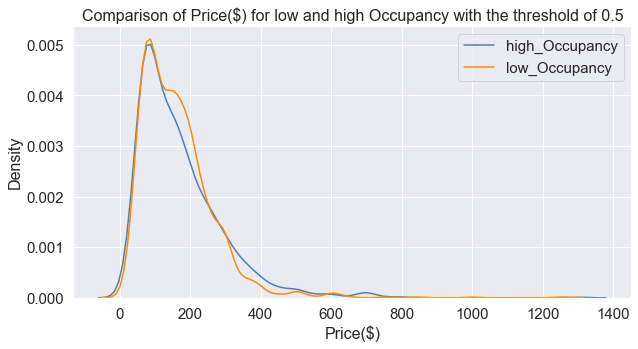

In [63]:
vis_diff_base(listings_prd, 'price', 'non_avail_rate', 0.5, 'Price($)', 'Occupancy')

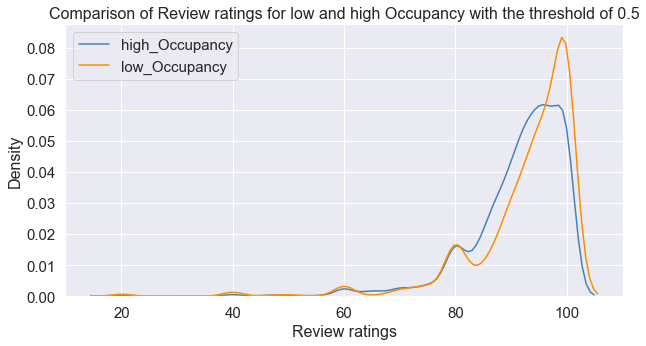

In [64]:
vis_diff_base(listings_prd, 'review_scores_rating', 'non_avail_rate', 0.5, 'Review ratings', 'Occupancy')

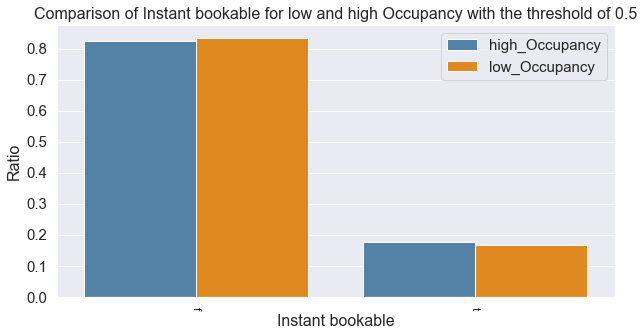

In [65]:
vis_diff_base(listings_prd, 'instant_bookable', 'non_avail_rate', 0.5, 'Instant bookable', 'Occupancy')

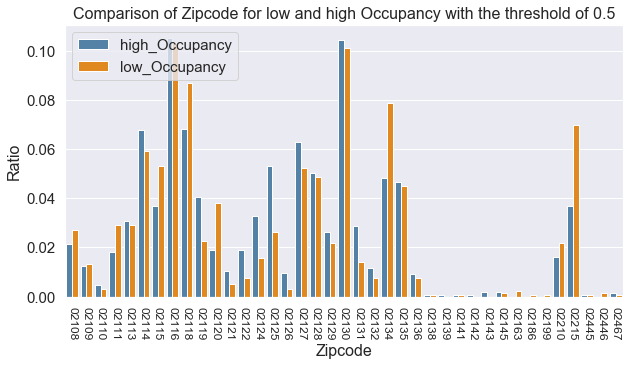

In [66]:
vis_diff_base(listings_prd, 'zipcode', 'non_avail_rate', 0.5, 'Zipcode', 'Occupancy')

From the figures above, it seems that for high/low occupancy, the distribution of other features quite similar.<br/>
Similarly, we use 133 as the threshold to classify low and high price, since this value divide the whole number of properties roughly into two halves.

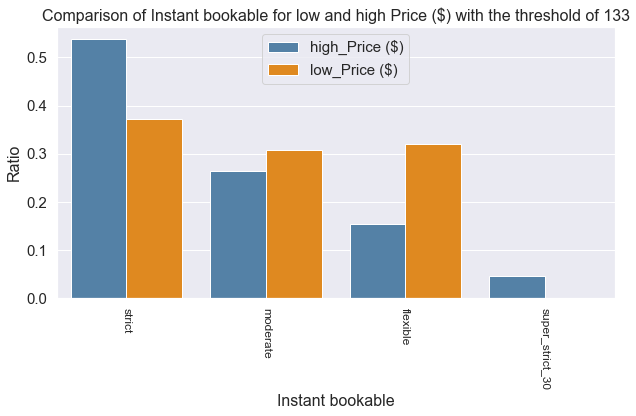

In [67]:
vis_diff_base(listings_prd, 'cancellation_policy', 'price', 133, 'Instant bookable', 'Price ($)')

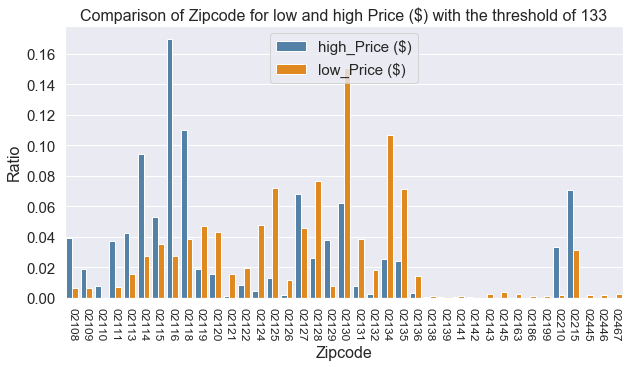

In [68]:
vis_diff_base(listings_prd, 'zipcode', 'price', 133, 'Zipcode', 'Price ($)')

It is clearly observed that, for the same feature zipcode, the difference is more significant for low/high price than low/high occupancy. Also, we can see that properties with higher price tend to have a more strict cancellation policy.

## c. Predictive model

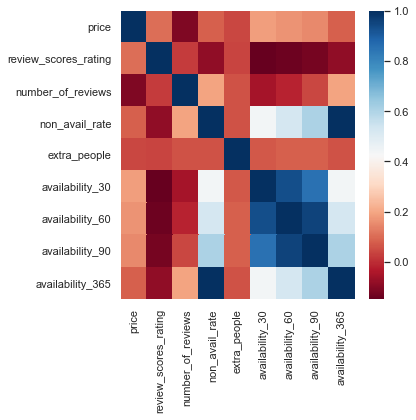

In [69]:
# Check the correlations between features and the price
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(listings_prd.corr(), cmap='RdBu')
plt.tight_layout()
plt.savefig('./figs/correlation.png', dpi = 300, bbox_inches='tight')
plt.show()

In [70]:
# We can see that availability_365 seems duplicate non_avail_rate, so remove it
listings_prd.drop('availability_365', axis=1, inplace=True)

In [71]:
# Creat one-hot variables for the categorical features except for amenities
cat_cols = listings_prd.select_dtypes(include=['object', 'category']).columns.drop('amenities')

def create_dummy_df(df, cat_cols, dummy_na=False):
    '''
    Function to create one-hot columns for categorical features and remove the original columns
    
    Args:
        df: a Datafram
        cat_cols: a list of column names to transform
        dummy_na: a boolean, if add a column to indicate NaNs
        
    Returns:
        Dataframe: a Datafrmae after transforming the specified catergorical columns
    '''
    
    for col in cat_cols:
        try:
            df = pd.concat([df.drop(col, axis=1), 
                            pd.get_dummies(df[col], prefix=col, prefix_sep='_', dummy_na=dummy_na, drop_first=False)], axis=1)
        except:
            continue
    return df

listings_prd = create_dummy_df(listings_prd, cat_cols)

In [72]:
# Transform the amentites column into a list of keywords
listings_prd.amenities.head()

0    {TV,Internet,"Wireless Internet","Air Conditio...
1    {TV,"Cable TV","Wireless Internet","Air Condit...
2    {TV,Internet,"Wireless Internet","Air Conditio...
3    {Internet,"Wireless Internet","Air Conditionin...
4    {"Cable TV","Wireless Internet","Air Condition...
Name: amenities, dtype: object

In [73]:
listings_prd['amenities'] = listings_prd['amenities'].str.replace('"', '').str.replace('{','').   \
                            str.replace('}', '').str.lower().str.split(',')

In [74]:
# Find the unique keywords for amenities
unique_amenities = set()
listings_prd['amenities'].apply(unique_amenities.update)
print(unique_amenities)

{'', 'free parking on street', 'smoking allowed', 'translation missing: en.hosting_amenity_50', 'shampoo', 'iron', 'paid parking off premises', 'carbon monoxide detector', 'kitchen', 'dog(s)', 'hot tub', 'buzzer/wireless intercom', 'tv', 'family/kid friendly', 'essentials', 'internet', 'cable tv', 'first aid kit', 'wheelchair accessible', 'gym', 'doorman', 'elevator in building', 'lock on bedroom door', 'breakfast', 'pets live on this property', 'laptop friendly workspace', 'washer / dryer', 'indoor fireplace', 'cat(s)', '24-hour check-in', 'pool', 'air conditioning', 'safety card', 'wireless internet', 'suitable for events', 'washer', 'heating', 'other pet(s)', 'hangers', 'free parking on premises', 'fire extinguisher', 'pets allowed', 'smoke detector', 'translation missing: en.hosting_amenity_49', 'dryer', 'hair dryer'}


In [75]:
# Remove unnecessary keywords
unique_amenities.remove('')
unique_amenities.remove('translation missing: en.hosting_amenity_49')
unique_amenities.remove('translation missing: en.hosting_amenity_50')

In [76]:
# Add in the columns for the one-hot encodings for amenities
for keyword in unique_amenities:
    listings_prd[keyword] = listings_prd['amenities'].apply(lambda wordlist: 1 if keyword in wordlist else 0)
    
listings_prd.drop('amenities', axis=1, inplace=True)

In [77]:
listings_prd.head()

,price,review_scores_rating,number_of_reviews,non_avail_rate,extra_people,availability_30,availability_60,availability_90,zipcode_02108,zipcode_02109,zipcode_02110,zipcode_02111,zipcode_02113,zipcode_02114,zipcode_02115,zipcode_02116,zipcode_02118,zipcode_02119,zipcode_02120,zipcode_02121,zipcode_02122,zipcode_02124,zipcode_02125,zipcode_02126,zipcode_02127,zipcode_02128,zipcode_02129,zipcode_02130,zipcode_02131,zipcode_02132,zipcode_02134,zipcode_02135,zipcode_02136,zipcode_02138,zipcode_02139,zipcode_02141,zipcode_02142,zipcode_02143,zipcode_02145,zipcode_02163,zipcode_02186,zipcode_02199,zipcode_02210,zipcode_02215,zipcode_02445,zipcode_02446,zipcode_02467,host_is_superhost_f,host_is_superhost_t,property_type_Apartment,...,cancellation_policy_super_strict_30,require_guest_profile_picture_f,require_guest_profile_picture_t,host_identity_verified_f,host_identity_verified_t,require_guest_phone_verification_f,require_guest_phone_verification_t,free parking on street,smoking allowed,shampoo,iron,paid parking off premises,carbon monoxide detector,kitchen,dog(s),hot tub,buzzer/wireless intercom,tv,family/kid friendly,essentials,internet,cable tv,first aid kit,wheelchair accessible,gym,doorman,elevator in building,lock on bedroom door,breakfast,pets live on this property,laptop friendly workspace,washer / dryer,indoor fireplace,cat(s),24-hour check-in,pool,air conditioning,safety card,wireless internet,suitable for events,washer,heating,other pet(s),hangers,free parking on premises,fire extinguisher,pets allowed,smoke detector,dryer,hair dryer
0,65.0,94.0,36,0.983562,0.0,26,54,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,...,0,1,0,0,1,1,0,0,0,1,1,0,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,1,1,1,1,1
1,65.0,98.0,41,0.873973,20.0,19,46,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,0,0,1,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,1,0,0,1,0,0,1,1,0
2,75.0,100.0,1,0.268493,25.0,6,16,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,1,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,1,1,0,1,1,0,1,1,1,0,1,1,1
3,79.0,99.0,29,0.915068,0.0,13,34,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,1,0,0,0,1,1,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1
4,75.0,100.0,8,0.158904,0.0,5,28,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,1,1,0,0,1,0,0
